In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(100)

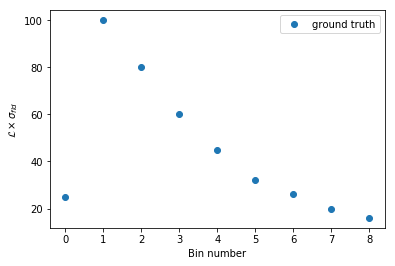

In [2]:
ground_truth = np.array([25, 100, 80, 60, 45, 32, 26, 20, 16])
n_dim = len(ground_truth)

plt.plot(np.arange(n_dim), ground_truth, "o", label="ground truth")
plt.ylabel(r"$\mathcal{L} \times \sigma_{fid}$")
plt.xlabel(r"Bin number")
plt.legend()
plt.show()

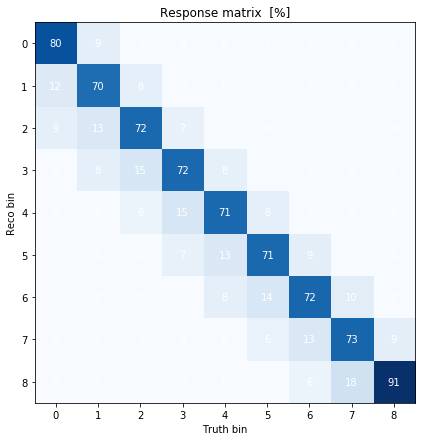

In [3]:
def normalise_along_axis_1 (mat) :
    if type(mat) != np.ndarray : raise ValueError("Argument is not a numpy array")
    if len(mat.shape) != 2     : raise ValueError("Argument is not a matrix")
    for i in range(n_dim) :
        integral = np.sum(mat[:,i])
        mat[:,i] = mat[:,i] / integral

def add_off_diagonal_elements(mat) :
    for i in range(n_dim) :
        for j in range(n_dim) :
            if j == i-1 : mat[j][i] = 0.1 + 0.02*np.random.normal(size=(1,))
            if j == i+1 : mat[j][i] = 0.2 + 0.03*np.random.normal(size=(1,))
            if j == i+2 : mat[j][i] = 0.1 + 0.02*np.random.normal(size=(1,))
    normalise_along_axis_1(mat)

response_matrix = np.eye(n_dim)
add_off_diagonal_elements(response_matrix)

fig = plt.figure(figsize=(7,7))
plt.imshow(response_matrix, cmap="Blues")

for i in range(n_dim):
    for j in range(n_dim):
        plt.gca().text(j, i, f"{100*response_matrix[i, j]:.0f}", ha="center", va="center", color="w")
        
plt.title("Response matrix  [%]")
plt.ylabel("Reco bin")
plt.xlabel("Truth bin")
plt.show()

In [4]:
def unfold (reco_dist, response_matrix) :
    return np.matmul(np.linalg.inv(response_matrix), reco_dist)

def unfold_with_errors (reco_dist, reco_errs, response_matrix) :
    inv_response    = np.linalg.inv(response_matrix)
    inv_response_sq = np.multiply(inv_response, inv_response)
    reco_errs_sq    = np.multiply(reco_errs, reco_errs)
    ret_vals = np.matmul(inv_response, reco_dist)
    ret_errs = np.sqrt(np.matmul(inv_response_sq, reco_errs_sq))
    return ret_vals, ret_errs

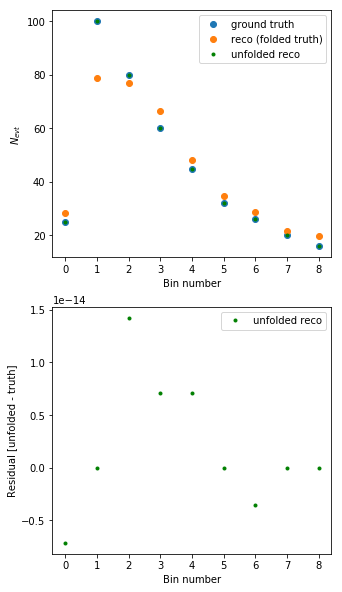

In [5]:
expected_reco_dist = np.matmul(response_matrix, ground_truth)
unfolded_reco_dist = unfold(expected_reco_dist, response_matrix)

fig = plt.figure(figsize=(5,10))
fig.add_subplot(211)
plt.plot(np.arange(n_dim), ground_truth      , "o", markersize=6, label="ground truth")
plt.plot(np.arange(n_dim), expected_reco_dist, "o", label="reco (folded truth)")
plt.plot(np.arange(n_dim), unfolded_reco_dist, "o", c="green", markersize=3, label="unfolded reco")
plt.ylabel(r"$N_{evt}$")
plt.xlabel(r"Bin number")
plt.legend()

fig.add_subplot(212)
plt.plot(np.arange(n_dim), unfolded_reco_dist - ground_truth, "o", c="green", markersize=3, label="unfolded reco")
plt.ylabel(r"Residual [unfolded - truth]")
plt.xlabel(r"Bin number")
plt.legend()

plt.show()

In [6]:
class ProbGenerator_1D :
    def __init__ (self, dist=None) :
        if dist is not None :
            self.set_underlying_dist(dist)
    def set_underlying_dist (self, dist) :
        self.dist = dist / sum(dist)
        self.cumulative_dist = np.zeros(len(self.dist))
        self.cumulative_dist[0] = self.dist[0]
        for i in range(1, len(self.dist)) :
            self.cumulative_dist[i] = self.cumulative_dist[i-1] + self.dist[i]
    def generate (self, num_points=1) :
        rnd_numbers = np.random.uniform(0, 1, num_points)
        ret = []
        for rnd in rnd_numbers :
            idx = 0
            while self.cumulative_dist[idx] < rnd : idx = idx + 1
            if idx > len(self.dist) : idx = len(self.dist)
            ret.append(idx)
        return ret

In [7]:
class MCGenerator :
    def __init__ (self, truth_dist, response_matrix) :
        self.truth_dist      = truth_dist
        self.response_matrix = response_matrix
    def generate (self, num_points) :
        truth_generator = ProbGenerator_1D(self.truth_dist)
        reco_generators = [ProbGenerator_1D(self.response_matrix[:,i]) for i in range(len(self.truth_dist))]
        MC_events = np.zeros(shape=(num_points, 2), dtype=int)
        events_truth = truth_generator.generate(num_points)
        for evt_idx, evt_truth in enumerate(events_truth) :
            evt_reco = reco_generators[evt_truth].generate()
            MC_events[evt_idx, 0] = evt_truth
            MC_events[evt_idx, 1] = evt_reco[0]
        return MC_events
        

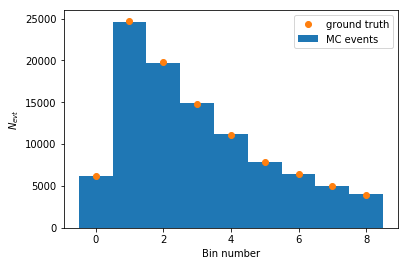

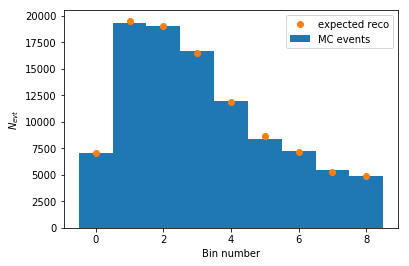

In [22]:
num_events = 100000
MC_generator = MCGenerator(ground_truth, response_matrix)
MC_events = MC_generator.generate(num_events)

MC_events_truth = MC_events[:,0]
MC_events_reco  = MC_events[:,1]

plt.hist(MC_events_truth, bins=np.linspace(-0.5, n_dim-0.5, n_dim+1), label="MC events")
projected_truth_for_MC = num_events * ground_truth / sum(ground_truth)
plt.plot(np.arange(n_dim), projected_truth_for_MC, "o", markersize=6, label="ground truth")
plt.ylabel("$N_{evt}$")
plt.xlabel("Bin number")
plt.legend()
plt.show()

plt.hist(MC_events_reco, bins=np.linspace(-0.5, n_dim-0.5, n_dim+1), label="MC events")
projected_reco_for_MC = num_events * expected_reco_dist / sum(expected_reco_dist)
plt.plot(np.arange(n_dim), projected_reco_for_MC, "o", markersize=6, label="expected reco")
plt.ylabel("$N_{evt}$")
plt.xlabel("Bin number")
plt.legend()
plt.show()

In [23]:
def get_response_matrix_from_data (events) :
    ret = np.zeros(shape=(n_dim, n_dim))
    for evt in events :
        ret[evt[1], evt[0]] = ret[evt[1], evt[0]] + 1
    normalise_along_axis_1(ret)
    return ret    

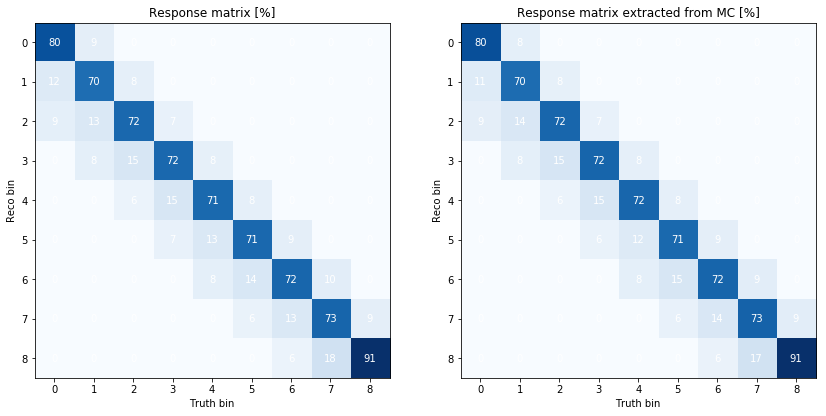

In [24]:
test_response_matrix = get_response_matrix_from_data(MC_events)

fig = plt.figure(figsize=(14,7))

fig.add_subplot(121)
plt.imshow(response_matrix, cmap="Blues")

for i in range(n_dim):
    for j in range(n_dim):
        plt.gca().text(j, i, f"{100*response_matrix[i, j]:.0f}", ha="center", va="center", color="w")
        
plt.title("Response matrix [%]")
plt.ylabel("Reco bin")
plt.xlabel("Truth bin")

fig.add_subplot(122)
plt.imshow(test_response_matrix, cmap="Blues")

for i in range(n_dim):
    for j in range(n_dim):
        plt.gca().text(j, i, f"{100*test_response_matrix[i, j]:.0f}", ha="center", va="center", color="w")
        
plt.title("Response matrix extracted from MC [%]")
plt.ylabel("Reco bin")
plt.xlabel("Truth bin")

plt.show()

In [25]:
def get_dist_from_events (events, axis) :
    ret = np.zeros(shape=(n_dim,))
    for evt in events :
        bin_idx      = evt[axis]
        ret[bin_idx] = ret[bin_idx] + 1
    return ret

In [40]:
n_toys = 5000
split_idx = int(num_events*0.9)

pulls = [[] for i in range(n_dim)]

train_events = MC_events[:split_idx]
test_events  = MC_events[split_idx:]
trained_response_matrix = get_response_matrix_from_data(train_events)
trained_truth_dist = get_dist_from_events(train_events, 0) / sum(train_events[:,0])

for toy_idx in range(n_toys) :
    if toy_idx==0 or (1+toy_idx)*10 % n_toys == 0 :
        pct = int(100*(1+toy_idx)/n_toys)
        bar = "[" + ("=="*int(pct / 10)).ljust(20) + "]"
        sys.stdout.write("\r"+bar+f" {pct}% complete")
        sys.stdout.flush()
    poisson_weights = np.random.poisson(1, len(test_events))
    bootstrapped_test_events = []
    for evt_idx, evt in enumerate(test_events) :
        for n_times in range(poisson_weights[evt_idx]) :
            bootstrapped_test_events.append(evt)
    test_reco_dist = get_dist_from_events(bootstrapped_test_events, 1)
    reco_dist_errs = np.sqrt(test_reco_dist)
    unf_vals, unf_errs = unfold_with_errors(test_reco_dist, reco_dist_errs, trained_response_matrix)
    this_pulls = np.divide((unf_vals - (sum(test_events[:,0]) * trained_truth_dist)), unf_errs)
    for dim_idx in range(n_dim) :
        pulls[dim_idx].append(this_pulls[dim_idx])


(9,)
[====================] 100% complete

In [41]:
for idx in range(n_dim) :
    mean = np.mean(pulls[idx])
    std  = np.std(pulls[idx])
    print(f"MEAN = {mean:.3f},  STD = {std:.3f}")

MEAN = -0.836,  STD = 1.000
MEAN = -0.465,  STD = 0.971
MEAN = -0.913,  STD = 1.002
MEAN = 0.123,  STD = 0.998
MEAN = -1.785,  STD = 1.027
MEAN = 1.583,  STD = 0.963
MEAN = 0.845,  STD = 0.959
MEAN = -0.317,  STD = 1.022
MEAN = -0.249,  STD = 1.006


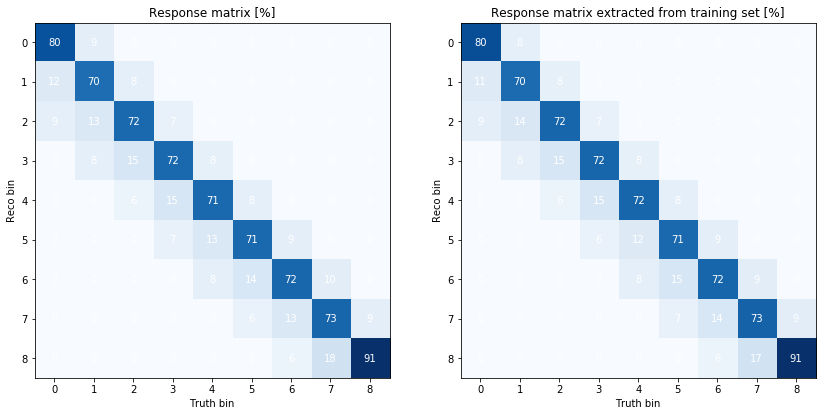

In [42]:
fig = plt.figure(figsize=(14,7))

fig.add_subplot(121)
plt.imshow(response_matrix, cmap="Blues")

for i in range(n_dim):
    for j in range(n_dim):
        plt.gca().text(j, i, f"{100*response_matrix[i, j]:.0f}", ha="center", va="center", color="w")
        
plt.title("Response matrix [%]")
plt.ylabel("Reco bin")
plt.xlabel("Truth bin")

fig.add_subplot(122)
plt.imshow(trained_response_matrix, cmap="Blues")

for i in range(n_dim):
    for j in range(n_dim):
        plt.gca().text(j, i, f"{100*trained_response_matrix[i, j]:.0f}", ha="center", va="center", color="w")
        
plt.title("Response matrix extracted from training set [%]")
plt.ylabel("Reco bin")
plt.xlabel("Truth bin")

plt.show()